In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
from ray import tune

In [3]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MAE, MSE, RMSE
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

In [4]:
from neuralforecast.models import NHITS

In [5]:
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [6]:
df = pd.read_excel('S&P 500 Realized Volatility (NBEATSx).xlsx',index_col='Date',parse_dates=True)

In [7]:
Y_train = df

In [8]:
Y_train.reset_index(inplace=True)

In [10]:
Y_train.rename(columns={'Date':'ds'}, inplace=True)

In [11]:
Y_train.rename(columns={'Realised':'y'}, inplace=True)

In [12]:
Y_train.head()

,ds,unique_id,y,S&P 500 Financial Turbulence,VIX,Covid
0,2017-11-02,Airline1,0.004873,806.442547,9.93,0
1,2017-11-03,Airline1,0.003036,702.337034,9.14,0
2,2017-11-06,Airline1,0.001808,529.197112,9.40,0
3,2017-11-07,Airline1,0.003225,512.157114,9.89,0
4,2017-11-08,Airline1,0.002568,493.752126,9.78,0


<AxesSubplot:>

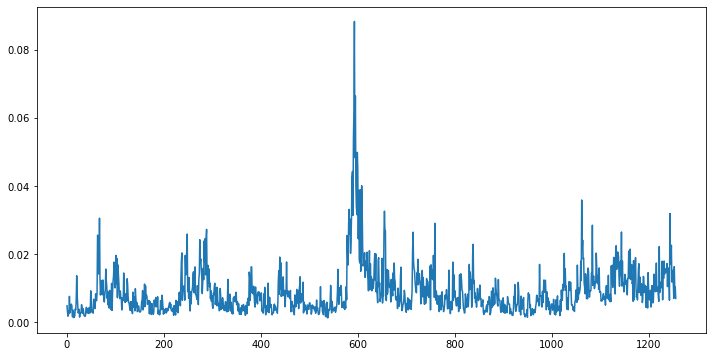

In [13]:
Y_train["y"].plot(figsize=(12,6))

In [41]:
RMSE=[]
Accuracy=[]

In [227]:
model = NBEATSx(h=1, input_size=21,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[4, 4],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['S&P 500 Financial Turbulence','VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=random.randint(0, 100))


Global seed set to 26


In [228]:
fcst = NeuralForecast(
    models=[model],
    freq=CustomBusinessDay(calendar=USFederalHolidayCalendar())
)

In [229]:
forecasts = fcst.cross_validation(df=Y_train,val_size=100,static_df=AirPassengersStatic,n_windows=None, test_size=252,step_size=1)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [230]:
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds','S&P 500 Financial Turbulence','VIX','Covid'])

In [231]:
Y_hat_df = Y_hat_df.drop(columns=['index','cutoff'])

In [232]:
Y_hat=Y_hat_df["NBEATSx"].values

In [233]:
Y_true=Y_hat_df["y"].values

In [234]:
RMSE.append(rmse(y=Y_true, y_hat=Y_hat))

In [235]:
Accuracy.append((1-mape(y=Y_true, y_hat=Y_hat))*100)

In [239]:
RMSE

[0.0034578374960992832,
 0.0036921198473281206,
 0.0036914316201903086,
 0.003454194036698932,
 0.0035027951942144075,
 0.0038012887710242205,
 0.0035486062301417058,
 0.0037651377187715735,
 0.0035540697206776152,
 0.003587378584503499,
 0.003544848525643436,
 0.0035579088014889883,
 0.0034293556097826404,
 0.003470983302764081,
 0.003635093673781768]

In [244]:
print("mean: %s" %(round(np.mean(RMSE),5)*100)+"%")

mean: 0.358%


In [245]:
print("stdv: %s" %(round(np.std(RMSE),5)*100)+"%")

stdv: 0.011000000000000001%


In [246]:
RMSE_CI_95_lower_bound=np.mean(RMSE)-2*np.std(RMSE)
RMSE_CI_95_upper_bound=np.mean(RMSE)+2*np.std(RMSE)
print("95 percent CI lower bound: %s" %(round(RMSE_CI_95_lower_bound,5)*100)+"%")
print("95 percent CI upper bound: %s" %(round(RMSE_CI_95_upper_bound,5)*100)+"%")

95 percent CI lower bound: 0.336%
95 percent CI upper bound: 0.38%


In [247]:
RMSE_CI_99_lower_bound=np.mean(RMSE)-3*np.std(RMSE)
RMSE_CI_99_upper_bound=np.mean(RMSE)+3*np.std(RMSE)
print("99.7 percent CI lower bound: %s" %(round(RMSE_CI_99_lower_bound,5)*100)+"%")
print("99.7 percent CI upper bound: %s" %(round(RMSE_CI_99_upper_bound,5)*100)+"%")

99.7 percent CI lower bound: 0.325%
99.7 percent CI upper bound: 0.391%


In [237]:
Accuracy

[77.31009334323973,
 76.66075361246834,
 76.94936286972779,
 79.31145620317592,
 78.70540414365549,
 75.52047221394855,
 77.83368519894873,
 76.82472317350575,
 77.06588907051368,
 76.55698827558378,
 77.95164440491756,
 78.77113061772125,
 78.02617863992728,
 80.25014738284312,
 76.19640482602486]

In [240]:
print("mean: %s" %(round(np.mean(Accuracy),2))+"%")

mean: 77.6%


In [241]:
print("stdv: %s" %(round(np.std(Accuracy),2))+"%")

stdv: 1.23%


In [242]:
Accuracy_CI_95_lower_bound=np.mean(Accuracy)-2*np.std(Accuracy)
Accuracy_CI_95_upper_bound=np.mean(Accuracy)+2*np.std(Accuracy)
print("95 percent CI lower bound: %s" %round(Accuracy_CI_95_lower_bound,2)+"%")
print("95 percent CI upper bound: %s" %round(Accuracy_CI_95_upper_bound,2)+"%")

95 percent CI lower bound: 75.14%
95 percent CI upper bound: 80.05%


In [243]:
Accuracy_CI_99_lower_bound=np.mean(Accuracy)-3*np.std(Accuracy)
Accuracy_CI_99_upper_bound=np.mean(Accuracy)+3*np.std(Accuracy)
print("99.7 percent CI lower bound: %s" %round(Accuracy_CI_99_lower_bound,2)+"%")
print("99.7 percent CI upper bound: %s" %round(Accuracy_CI_99_upper_bound,2)+"%")

99.7 percent CI lower bound: 73.92%
99.7 percent CI upper bound: 81.28%


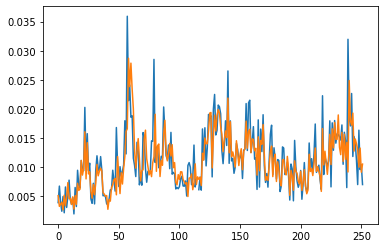

In [224]:
plt.plot(range(len(Y_hat)),Y_true)
plt.plot(range(len(Y_hat)),Y_hat)

(array([19012., 19013., 19014., 19015., 19016., 19017., 19018.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

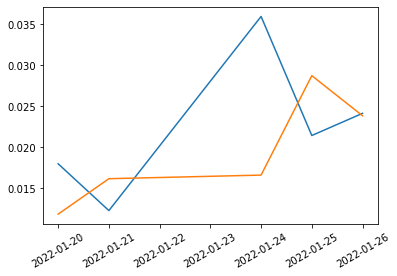

In [225]:
plt.plot(forecasts["ds"][55:60],Y_true[55:60])
plt.plot(forecasts["ds"][55:60],Y_hat[55:60])
plt.xticks(rotation=30)

(0.006, 0.028)

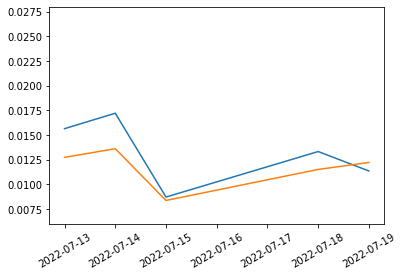

In [226]:
plt.plot(forecasts["ds"][175:180],Y_true[175:180])
plt.plot(forecasts["ds"][175:180],Y_hat[175:180])
plt.xticks(rotation=30)
ax = plt.gca()
ax.set_ylim(0.006, 0.028)